In [3]:
import pandas as pd
import numpy as np
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# 100% HDI that this link will go stale in the next 6 months = (0, 1)
link = "https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/EE_Datasets/us_macro_quarterly.xlsx"
df = pd.read_excel(link, storage_options={'User-Agent': 'Mozilla/5.0'}, index_col=0)

df.index = pd.to_datetime(
    df.index
    .str.replace(":01", "-01-01")
    .str.replace(":02", "-04-01")
    .str.replace(":03", "-07-01")
    .str.replace(":04", "-10-01")
)

df.rename(columns={"GDPC96": "GDP"}, inplace=True)

df = df[["GDP", "GS10", "TB3MS"]]
# This is an approximation of the annual growth rate
df["GDPGrowth"] = 400 * np.log(df["GDP"] / df["GDP"].shift())
# Term spread as the difference between 10-year and 3-month U.S. Treasury bonds
df["TSpread"] = df["GS10"] - df["TB3MS"]
df = df["1981":]
df

C:\Users\88ste\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,GDP,GS10,TB3MS,GDPGrowth,TSpread
1981-01-01,6628.634,12.960000,14.390000,8.200270,-1.430000
1981-04-01,6580.199,13.750000,14.906667,-2.933505,-1.156667
1981-07-01,6655.692,14.846667,15.053333,4.562976,-0.206667
1981-10-01,6578.035,14.086667,11.750000,-4.694544,2.336667
1982-01-01,6468.003,14.293333,12.813333,-6.747465,1.480000
...,...,...,...,...,...
2012-10-01,15539.628,1.706667,0.086667,0.145281,1.620000
2013-01-01,15583.948,1.950000,0.086667,1.139201,1.863333
2013-04-01,15679.677,1.996667,0.050000,2.449602,1.946667
2013-07-01,15839.347,2.710000,0.033333,4.052698,2.676667


In [5]:
data = df[["GDPGrowth", "TSpread"]][:-10]
test_data = df[["GDPGrowth", "TSpread"]][-10:]
data.shape, test_data.shape

((122, 2), (10, 2))

In [8]:
from matplotlib.colors import ColorConverter
import matplotlib.pyplot as plt
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}

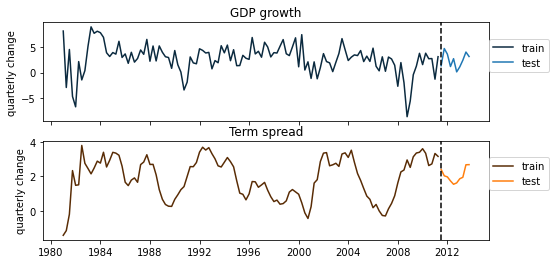

In [9]:
_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(data["GDPGrowth"], color=dark["C0"], label="train")
ax[0].plot(test_data["GDPGrowth"], color="C0", label="test")
ax[0].set_ylabel("quarterly change", fontsize=10)
ax[0].set_title("GDP growth")

ax[1].plot(data["TSpread"], color=dark["C1"], label="train")
ax[1].plot(test_data["TSpread"], color="C1", label="test")
ax[1].set_ylabel("quarterly change", fontsize=10)
ax[1].set_title("Term spread");

for axi in ax:
    axi.axvline(df.index[-10], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

In [10]:
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("GDPGrowth", "TSpread"),
    "cross_vars": ("GDPGrowth", "TSpread"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)
    ar_TSpread = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)

    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth, ar_TSpread], axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

In [23]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

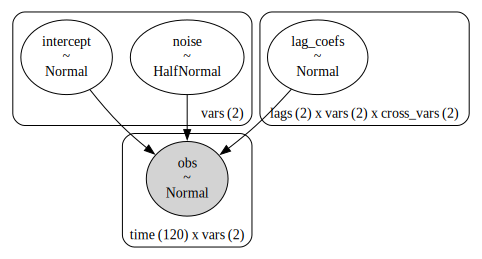

In [24]:
pm.model_to_graphviz(BVAR_model)

In [15]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=2, target_accept=0.6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


ValueError: Not enough samples to build a trace.